# Comparative analysis of multiple models

- Written by Sundong Kim, Institute for Basic Science
- Revised by Yeon Soo Choi, Research Unit, World Customs Organization
- Updated on: 2020.6.26

## Summary

Predictive analytics encompasses a variety of techniques from data mining, statistics, and machine learning, that analyze current and historical facts to make predictions about future or otherwise unknown events. Customs administrations can use predictive analytics for detecting under-valued or misclassified transactions. In this paper, we introduce how to design predictive modeling using open source libraries of Python. Using an anonymized import dataset, we formulate a binary classification problem to predict whether or not the transaction is illicit. To predict frauds, we design several features and train machine learning models on one year's worth of data. The performance of the learned models is compared using data in the following year. The later part of the tutorial covers how to store and compare the results of learned models. With this tutorial, we expect partner countries to design their own algorithms using their datasets and extract rules to support their legacy system.

For more details, please refer to the BACUDA series 6 available at http://www.wcoomd.org/en/topics/research/data-analytics.aspx (accessible after member-login)

## Outline
[**1. Data loading and preprocessing**](#id1)  
[**2. Undersampling in train data**](#id2)  
[**3. Deploy multiple models**](#id3)    
[**4. Save the results**](#id4)    
[**5. Retrieve the results for comparative analysis**](#id5)  
[**6. Visualize the performance of models**](#id6)

## 1. Data loading and preprocessing<a id='id1'></a>  

For more details in chapter 1, please refer to xxx

In [2]:
# Set environment (load libraries/packages)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
pd.set_option('display.max_columns', 100)

plt.style.use('fivethirtyeight')

In [3]:
# Load data
#df_raw = pd.read_csv('~/SyntheticDataGeneration_server/CTGAN/synthetic_data2.csv')
df_raw = pd.read_csv('../data/mgr3-1019.csv', low_memory=False)

# only imports
df_raw = df_raw[df_raw['destinacion_mercancia'] == 'IM']

In [4]:
# Select columns to use
# columns_to_use = ['year', 'month', 'day', 'OFFICE', 'IMPORTER.TIN',
#        'TARIFF.CODE', 'ORIGIN.CODE', 'CIF_USD_EQUIVALENT', 'QUANTITY',
#        'GROSS.WEIGHT','TOTAL.TAXES.USD', 'illicit']
# df_raw = df_raw[columns_to_use]

columns_to_use = [
    'anno', 'mes', 'aduana', 'contribuyente', 'inciso_arancelario', 'pais_origen_destino', 
    'cif', 'cuantia', 'peso_bruto','impuesto_total', 'illicit'
]

df_raw = df_raw[columns_to_use]

In [5]:
# Make a copy not to change the origincal data (to be used later)
df = df_raw.copy()

In [133]:
# Create additional numeric and categorical variables
def preprocess(df:pd.DataFrame, 
               args:list):
    """
    dtype df: dataframe
    dtype *args: strings (attribute names that want to be combined)
    """
    # create additional numeric variables
    df.loc[:, 'Unitprice'] = df['cif']/df['cuantia']
    df.loc[:, 'WUnitprice'] = df['cif']/df['peso_bruto']
    df.loc[:, 'TaxRatio'] = df['impuesto_total'] / df['cif']
    df.loc[:, 'TaxUnitquantity'] = df['impuesto_total'] / df['peso_bruto']
    
    # Create HS sub-classes
    df.loc[:, 'HS6'] = df['inciso_arancelario'].apply(lambda x: int(x) // 100000).astype(str) #HS10digit
    #df.loc[:, 'HS4'] = df['HS6'].apply(lambda x: int(x) // 100).astype(str)
    #df.loc[:, 'HS2'] = df['HS4'].apply(lambda x: int(x) // 100).astype(str)
    
    # Merge attributes
    
    df.loc[:,args] = df.loc[:,args].astype(str)
    
    # Generate all the pairs available from the selected categorical variables
    import itertools
    combinations = list(itertools.combinations(args, 2))
    
    # Run a loop for merging attributes 
    for (cat1, cat2) in combinations:
        ColName = cat1 + '&' + cat2
        df.loc[:,ColName] = df.loc[:,cat1]+'&'+df.loc[:,cat2]
    
    return df


# Identify high risky entities (importer, declarants, HScodes, Offices, origin countries, etc.)
def risk_profiling(df:pd.DataFrame, 
                   feature:str, 
                   topk_ratio:float):
    
    N_top10pct = int(df[feature].nunique()*topk_ratio)+1
    RiskH_list = list(df.groupby(feature)['illicit'].sum().sort_values(ascending=True).head(N_top10pct).index)
    
    return RiskH_list


def risk_tagging(df:pd.DataFrame, 
                 feature:str, 
                 RiskH_list:list):
    
    df.loc[:,'RiskH.'+feature] = np.where(df.loc[:,feature].isin(RiskH_list),1,0)
    
    return df


def plot_gain_lift(model):
    model_pred = model.predict(X_test)
    model_proba = model.predict_proba(X_test)

    temp = pd.DataFrame({
      'actual': y_test, 
      'p(0)': [p[0] for p in model_proba],
      'p(1)': [p[1] for p in model_proba],
      'predicted': model_pred,
    })

    temp = temp.sort_values(by=['p(1)'], ascending=False)
    
    plt.style.use('fivethirtyeight')
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
    
    gainsChart(temp.actual, ax=axes[0])
    liftChart(temp.actual, title=False, ax=axes[1])
    
    plt.suptitle(str(model).split('(')[0])
    plt.show()
    
    
def plot_roc_auc(real, pred, model):
    # compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(real, pred)
    roc_auc = auc(fpr, tpr)
    plt.style.use("fivethirtyeight")
    plt.figure(figsize=[8, 6])
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.title(str(model).split('(')[0])
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.legend(loc="lower right")
    plt.show()

In [7]:
# split train/valid/test set

TRAIN_YEAR = 2013
TEST_YEAR = 2014

train = df[df['anno']==TRAIN_YEAR]
test = df[df['anno']==TEST_YEAR]
print("Now, train-data has {} entries and {} features".format(*train.shape))
print("Now, test-data has {} entries and {} features".format(*test.shape))

Now, train-data has 139665 entries and 11 features
Now, test-data has 137278 entries and 11 features


In [12]:
# Preprocess train and test
train = preprocess(train, ['aduana', 'contribuyente','inciso_arancelario', 'pais_origen_destino'])
test = preprocess(test, ['aduana', 'contribuyente','inciso_arancelario', 'pais_origen_destino'])

# https://stackoverflow.com/questions/17477979/dropping-infinite-values-from-dataframes-in-pandas
train = train.replace([np.inf, -np.inf], np.nan).dropna()
test = test.replace([np.inf, -np.inf], np.nan).dropna()

D:\Users\javia\anaconda3\envs\ai\lib\site-packages\pandas\core\indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)


In [13]:
profile_candidates = ['aduana', 'contribuyente','inciso_arancelario', 'HS6', #'HS4', 'HS2', 
                      'pais_origen_destino']+[col for col in train.columns if '&' in col]
profile_candidates

['aduana',
 'contribuyente',
 'inciso_arancelario',
 'HS6',
 'pais_origen_destino',
 'aduana&contribuyente',
 'aduana&inciso_arancelario',
 'aduana&pais_origen_destino',
 'contribuyente&inciso_arancelario',
 'contribuyente&pais_origen_destino',
 'inciso_arancelario&pais_origen_destino',
 'RiskH.aduana&contribuyente',
 'RiskH.aduana&inciso_arancelario',
 'RiskH.aduana&pais_origen_destino',
 'RiskH.contribuyente&inciso_arancelario',
 'RiskH.contribuyente&pais_origen_destino',
 'RiskH.inciso_arancelario&pais_origen_destino']

In [14]:
# Risk profiling
for feature in profile_candidates:
    
    # Identify high risky entities 
    RiskH_list = risk_profiling(train, feature, 0.1)
    
    # Tag 'RiskH'
    train = risk_tagging(train, feature, RiskH_list)
    
    # Attention: Tags for test data are built from train data (not from test data)
    test = risk_tagging(test, feature, RiskH_list)

## 2. Undersampling (downsampling) in train-data <a id='id2'></a>  
If we train a machine with 10 fraud and 999990 non-frauds, the machine will be severely biased to predict non-frauds rather than frauds. Therefore, it is very important to have balanced number of frauds and non-frauds in the train-data. 

In [15]:
from sklearn.utils import resample

# Downsampling 
train_majority = train[train.illicit==0] # create a subset of non-frauds
train_minority = train[train.illicit==1] # create a subset of frauds
train_majority_downsampled = resample(train_majority, # population group
                                      replace=False,  # no duplicated selection is allowed
                                      n_samples=len(train_minority), # number of selection 
                                      random_state=123) # reproducibility
train_downsampled = pd.concat([train_majority_downsampled, train_minority])

# Use Downsampled data
train = train_downsampled
print("Now, train-dataset(undersampled) has {} entries and {} features".format(*train.shape))
print("Now, test-dataset has {} entries and {} features".format(*test.shape))

Now, train-dataset(undersampled) has 14038 entries and 39 features
Now, test-dataset has 135130 entries and 39 features


We will drop categorical variables from the data. 

In [82]:
# Create Fraud labels
y_train = train.illicit.values
y_test = test.illicit.values

# Select columns to use in a classifier
column_to_use = ['cif', 'cuantia','peso_bruto','impuesto_total', #'TARIFF.CODE', 
                 'Unitprice', 'WUnitprice', 'TaxRatio', 'TaxUnitquantity'] + [col for col in train.columns if 'RiskH' in col] 
# Save the number of columns
num_features = len(column_to_use)

# Convert data to np.arrays
X_train = train[column_to_use].values
X_test = test[column_to_use].values

print("Now, train-dataset(undersampled) has {} entries and {} features".format(*X_train.shape))
print("Now, test-dataset has {} entries and {} features".format(*X_test.shape))

Now, train-dataset(undersampled) has 14038 entries and 25 features
Now, test-dataset has 135130 entries and 25 features


## 3. Deploy multiple models <a id='id3'></a> 

In [83]:
# Prepare directory for saving results.
import os

if not os.path.exists('./results'):
    os.makedirs('./results')
    
if not os.path.exists('./results/intermediary'):
    os.makedirs('./results/intermediary')

In [57]:
# Load packages
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.utils import resample
import random
import time
import lightgbm as lgb
import xgboost as xgb
import catboost as cab
import string
import pickle
import csv

In [81]:
# Seven classifiers for comparison.
max_depth = 7
clf_list = [
            LogisticRegression(solver='lbfgs'),
            DecisionTreeClassifier(max_depth=max_depth),
            RandomForestClassifier(n_estimators=100, max_depth=max_depth),  # You can tune some hyper-parameters.
            AdaBoostClassifier(DecisionTreeClassifier(max_depth=max_depth)),
            xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
            lgb.LGBMClassifier(),
            cab.CatBoostClassifier(depth=max_depth, verbose=False),
           ]

In [84]:
# Initiate 7 models
clf_list

[LogisticRegression(),
 DecisionTreeClassifier(max_depth=7),
 RandomForestClassifier(max_depth=7),
 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=7)),
 XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
               colsample_bynode=None, colsample_bytree=None,
               eval_metric='logloss', gamma=None, gpu_id=None,
               importance_type='gain', interaction_constraints=None,
               learning_rate=None, max_delta_step=None, max_depth=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=100, n_jobs=None, num_parallel_tree=None,
               random_state=None, reg_alpha=None, reg_lambda=None,
               scale_pos_weight=None, subsample=None, tree_method=None,
               use_label_encoder=False, validate_parameters=None,
               verbosity=None),
 LGBMClassifier(),

## 4. Save the results <a id='id4'></a>

In [85]:
# Prepare to save results

# Set log file name
curr_time = int(time.time())
y_preds = []
LOG_FILE_NAME = './results/results_'+str(curr_time)+'.csv'

In [86]:
# Save results to LOG_FILE_NAME

# Open a log file where all the results will be saved
with open(LOG_FILE_NAME, 'a') as ff:
    wr = csv.writer(ff, dialect='excel')
    colnames=['Experiment_ID', 'TrainYear', 'TestYear', 'TrainLength', 'TestLength', 'Classifier', 
              'Features', 'Num_features', 'AUC', 'Time']
    wr.writerow(colnames)
    feature_used = '+'.join(column_to_use)
    
    print("Start training...")
    print('Classifier, numFeatures, AUC, Time(sec)')
    
    # Impute NaN
    X_train = np.nan_to_num(X_train, 0)
    X_test = np.nan_to_num(X_test, 0)
    
    for clf in clf_list:
        
        # Trick to make a unique identifier
        exp_id = ''.join(random.choices(string.ascii_uppercase + string.digits, k=10)) 

        # Check starting time
        start = time.time()
        
        # Train a classifier
        clf = clf.fit(X_train, y_train)
        
        # Predict frauds in test data
        y_pred = clf.predict_proba(X_test)[:, 1]
        
        # Append the predictions of each classifier
        y_preds.append(y_pred)
        
        # Save the predictions of each classifier in the name of 'exp_id' as .npy files
        np.save(f'./results/intermediary/y_pred_{exp_id}', y_pred)
        np.save(f'./results/intermediary/y_test_{exp_id}', y_test)
        
        # Save all the models as sav files
        filename = f'./results/intermediary/model_{exp_id}.sav'
        pickle.dump(clf, open(filename, 'wb'))
    
        # The reason to choose AUC: 
        # https://datascience.stackexchange.com/questions/806/advantages-of-auc-vs-standard-accuracy
        clas_auc = round(metrics.roc_auc_score(y_test, y_pred), 4)

        # Check the ending time
        done = time.time()
        
        # Check the runnin time
        elapsed = round(done-start, 4)
        
        # Print the results (content)
        print(f'{exp_id},{TRAIN_YEAR},{TEST_YEAR},{len(X_train)},{len(X_test)},{str(clf)[:10]},{feature_used},{num_features},{clas_auc},{elapsed}', file=ff)
        print(f'{str(clf)[:10]},     {num_features},    {clas_auc},  {elapsed}')

Start training...
Classifier, numFeatures, AUC, Time(sec)
LogisticRe,     25,    0.6512,  0.161
DecisionTr,     25,    0.6856,  0.141
RandomFore,     25,    0.6746,  1.959
AdaBoostCl,     25,    0.6971,  5.094
XGBClassif,     25,    0.7011,  1.019
LGBMClassi,     25,    0.6927,  0.509
<catboost.,     25,    0.7187,  10.094


## 5. Retrieve the results for comparative analysis <a id='id5'></a>

In [20]:
# Load the saved logs
# log = pd.read_csv(LOG_FILE_NAME)
# log

,Experiment_ID,TrainYear,TestYear,TrainLength,TestLength,Classifier,Features,Num_features,AUC,Time
0,V5DAODU57P,2013,2014,15594,86777,LogisticRe,CIF_USD_EQUIVALENT+QUANTITY+GROSS.WEIGHT+TOTAL...,19,0.5968,0.2796
1,QFT8KHXG2K,2013,2014,15594,86777,DecisionTr,CIF_USD_EQUIVALENT+QUANTITY+GROSS.WEIGHT+TOTAL...,19,0.6612,0.0833
2,UDYGID2VS1,2013,2014,15594,86777,RandomFore,CIF_USD_EQUIVALENT+QUANTITY+GROSS.WEIGHT+TOTAL...,19,0.7129,1.3999
3,934YQV9ASZ,2013,2014,15594,86777,AdaBoostCl,CIF_USD_EQUIVALENT+QUANTITY+GROSS.WEIGHT+TOTAL...,19,0.6661,1.7042
4,IYHSN9E4SE,2013,2014,15594,86777,XGBClassif,CIF_USD_EQUIVALENT+QUANTITY+GROSS.WEIGHT+TOTAL...,19,0.6914,1.4711
5,F16BN8K1W9,2013,2014,15594,86777,LGBMClassi,CIF_USD_EQUIVALENT+QUANTITY+GROSS.WEIGHT+TOTAL...,19,0.6876,1.0942
6,8CND1809R3,2013,2014,15594,86777,<catboost.,CIF_USD_EQUIVALENT+QUANTITY+GROSS.WEIGHT+TOTAL...,19,0.7029,22.7368


In [87]:
# Load the saved logs
log = pd.read_csv(LOG_FILE_NAME)
log

,Experiment_ID,TrainYear,TestYear,TrainLength,TestLength,Classifier,Features,Num_features,AUC,Time
0,RJJM466BYF,2013,2014,14038,135130,LogisticRe,cif+cuantia+peso_bruto+impuesto_total+Unitpric...,25,0.6512,0.161
1,0UNDE8XLLC,2013,2014,14038,135130,DecisionTr,cif+cuantia+peso_bruto+impuesto_total+Unitpric...,25,0.6856,0.141
2,5O1O97FNDW,2013,2014,14038,135130,RandomFore,cif+cuantia+peso_bruto+impuesto_total+Unitpric...,25,0.6746,1.959
3,UKHRAPV8UD,2013,2014,14038,135130,AdaBoostCl,cif+cuantia+peso_bruto+impuesto_total+Unitpric...,25,0.6971,5.094
4,QNC1YCVETL,2013,2014,14038,135130,XGBClassif,cif+cuantia+peso_bruto+impuesto_total+Unitpric...,25,0.7011,1.019
5,MLN61U5U1D,2013,2014,14038,135130,LGBMClassi,cif+cuantia+peso_bruto+impuesto_total+Unitpric...,25,0.6927,0.509
6,K4WOUBB3JJ,2013,2014,14038,135130,<catboost.,cif+cuantia+peso_bruto+impuesto_total+Unitpric...,25,0.7187,10.094


In [88]:
# Create a dictionary matching Experiment_IDs with Classifiers
d_id_clf = dict(zip(list(log['Experiment_ID']), list(log['Classifier'])))
d_id_clf

{'RJJM466BYF': '              LogisticRe',
 '0UNDE8XLLC': '              DecisionTr',
 '5O1O97FNDW': '              RandomFore',
 'UKHRAPV8UD': '              AdaBoostCl',
 'QNC1YCVETL': '              XGBClassif',
 'MLN61U5U1D': '              LGBMClassi',
 'K4WOUBB3JJ': '              <catboost.'}

In [89]:
# Generate a default dictionary (dresults) to save all the results of classifiers as sub-dicts

from collections import defaultdict

dresults = defaultdict(dict)

for exp_id in list(d_id_clf.keys()):  
    dresults[exp_id]['y_pred'] = np.load('./results/intermediary/y_pred_{}.npy'.format(exp_id))
    dresults[exp_id]['y_test'] = np.load('./results/intermediary/y_test_{}.npy'.format(exp_id))
    dresults[exp_id]['classifier'] = d_id_clf[exp_id]
    dresults[exp_id]['Precision'] = defaultdict(dict)
    dresults[exp_id]['Recall'] = defaultdict(dict)
    dresults[exp_id]['F1-score'] = defaultdict(dict)

    y_pred = dresults[exp_id]['y_pred']
    y_test = dresults[exp_id]['y_test']
    
    y = np.transpose([y_pred, y_test])
    
    # Sort by predicted value (first column)
    ys1 = y[y[:,0].argsort()[::-1]]  
    
    for i in range(1, 101): # Selectivity ratio from 1% to 100%
        topi = ys1[:(len(ys1)*i)//100, :]  # Select top-i percents of suspicious transactions 
        precision = np.mean(topi[:, 1])
        recall = sum(topi[:, 1])/sum(y_test)
        f1score = (precision*recall)/(precision+recall)
        
        dresults[exp_id]['Precision'][i] = precision
        dresults[exp_id]['Recall'][i] = recall
        dresults[exp_id]['F1-score'][i] = f1score

In [94]:
# Print the performance (selected METRIC) of a specific classifier

# Select an indicator (Recal, Precision, Recall or F1-score)
METRIC = 'Recall'

# Select a classifier
ID = list(dresults.keys())[-1]
classifier = dresults[ID]['classifier']

print(f'By using clf:{classifier}, (expID={ID})')

for i, val in dresults[ID][METRIC].items():
    if i in [1, 2, 5, 10, 30, 50, 70, 100]:
        print(f'{METRIC} of Top-{i}% suspicious transaction is {round(val, 4)}')

By using clf:              <catboost., (expID=K4WOUBB3JJ)
Recall of Top-1% suspicious transaction is 0.1375
Recall of Top-2% suspicious transaction is 0.2406
Recall of Top-5% suspicious transaction is 0.3482
Recall of Top-10% suspicious transaction is 0.4118
Recall of Top-30% suspicious transaction is 0.5791
Recall of Top-50% suspicious transaction is 0.7401
Recall of Top-70% suspicious transaction is 0.8724
Recall of Top-100% suspicious transaction is 1.0


## 6. Visualize the performance of models <a id='id6'></a>

In [95]:
from itertools import islice

def _take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

def basicplot(d, metric, strr='', topn=100):
    """
    Plot a graph for a metric
    """
    Dprev = d[metric]
    D = _take(topn, Dprev.items())
    plt.figure(figsize=(10, 5))
    plt.rcParams.update({'font.size': 14})
    plt.bar(range(1, len(D)+1), [b for (a,b) in D], align='center')
    plt.title('Performance of ' + dresults[ID1]['classifier'])
    
    l = [1,5,10,30,50,70,100]
    l1 = [i for i in l if i <= topn]
    l2 = l1.copy()
    f = l2.pop()
    l2.append(str(f)+'%')
    
    plt.xticks(l1, l2)
    plt.ylabel(metric+strr)
    plt.xlabel('Inspection rate')
    plt.show()

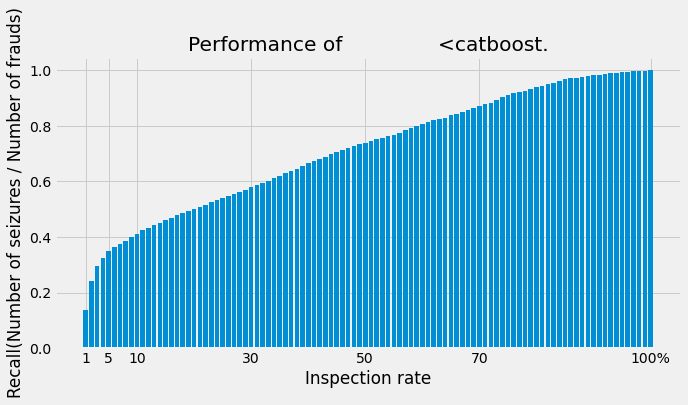

In [96]:
# Select a classifier
ID1 = list(dresults.keys())[-1]

basicplot(dresults[ID1], # classifier
          'Recall', # METRIC (performance indicator)
          '(Number of seizures / Number of frauds)', # y_label 
          100) # Max value of x-axis

In [97]:
def plotForComparison(metric, topn=30):
    """
    metric = str (Precision, Recall, Seized Revenue, F1-score)
    topn = int (range from 1 to 100, default=100)
    """
    import seaborn as sns
    daata = {}
    for i in range(len(dresults.keys())):
        ID = list(dresults.keys())[i]
        daata[dresults[ID]['classifier']]=list(dresults[ID][metric].values())
    daata = pd.DataFrame.from_dict(daata)    
    daata.index += 1 
    sns.set(style="whitegrid")
    plt.figure(figsize=(15, 10))
    plt.xlabel('Inspection rate(%)')
    plt.ylabel(metric)
    sns.lineplot(data=daata.iloc[:, -6:].head(topn), markers=True, linewidth=1)

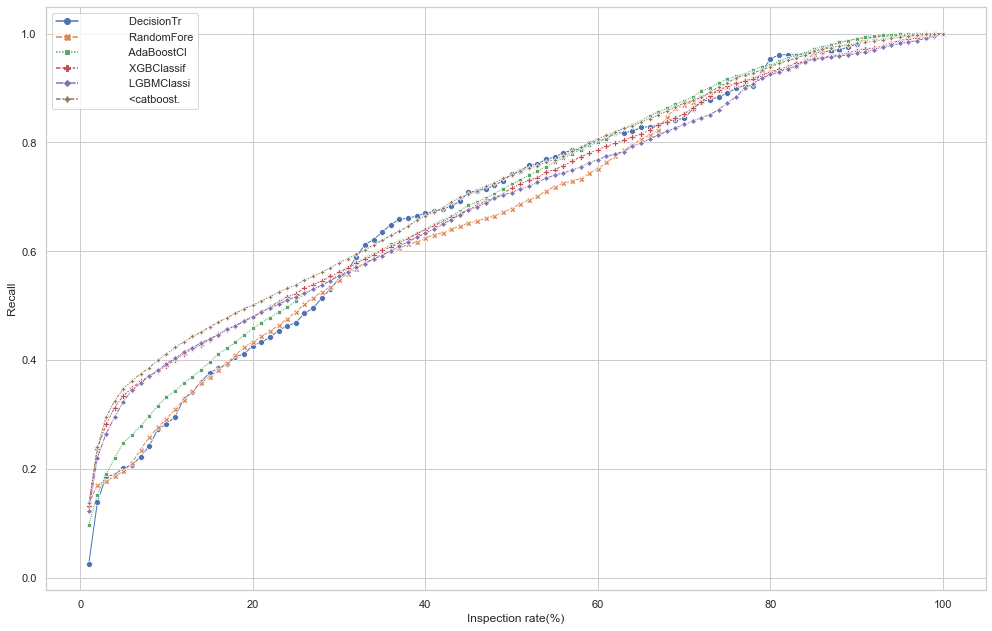

In [98]:
plotForComparison('Recall', topn=100)

In [161]:
for x in log['Experiment_ID']:
    print(x)

RJJM466BYF
0UNDE8XLLC
5O1O97FNDW
UKHRAPV8UD
QNC1YCVETL
MLN61U5U1D
K4WOUBB3JJ


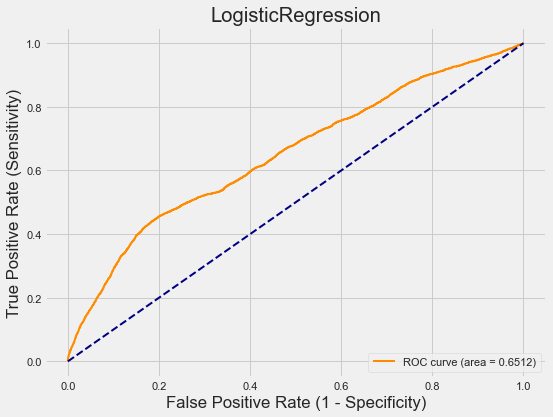

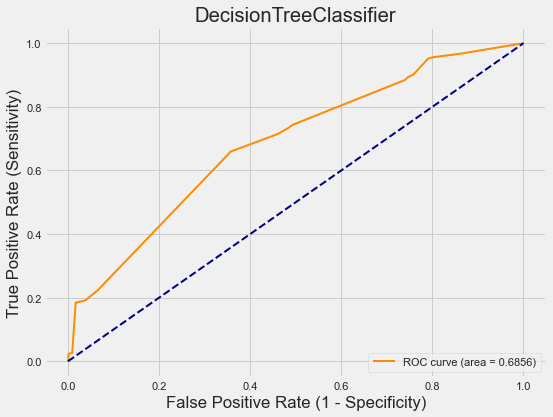

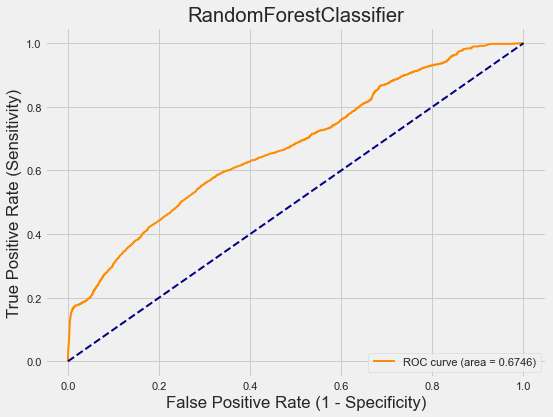

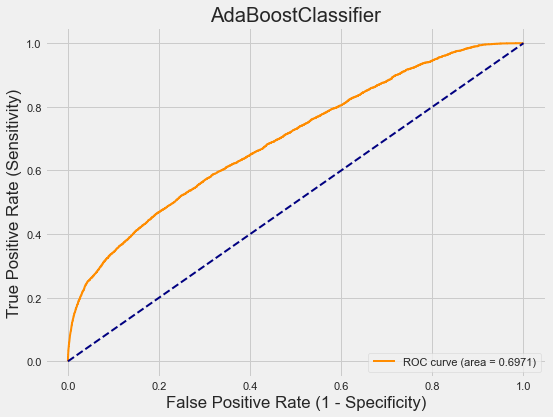

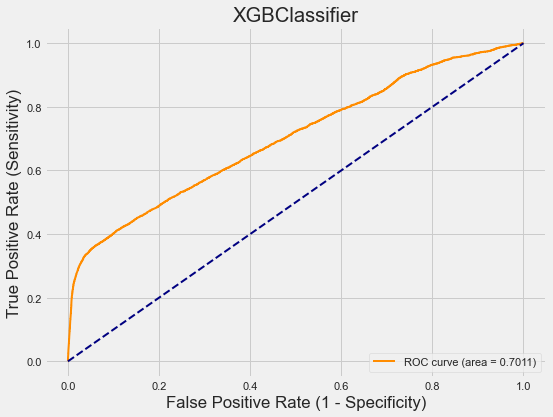

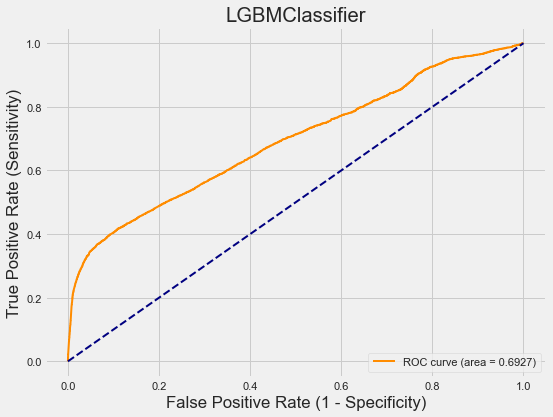

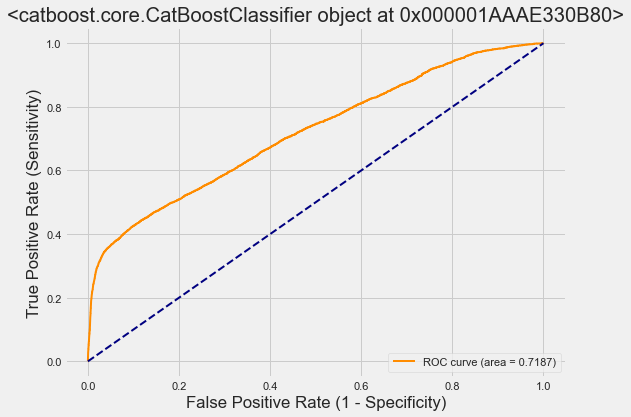

In [172]:
from sklearn.metrics import classification_report, roc_curve, auc
from dmba import classificationSummary, liftChart, gainsChart

for x in log['Experiment_ID']:
    model_name = x #'MLN61U5U1D'
    model = pickle.load(open(f'./results/intermediary/model_{model_name}.sav', 'rb'))
    plot_roc_auc(dresults[model_name]['y_test'], dresults[model_name]['y_pred'], model)
    #plot_gain_lift(model_K4WOUBB3JJ)